# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Utility code

Please ignore the content of these cells, they provide some helpful methods but are not part of the workshop.

Run them one at a time, then click the arrow by "Utility code" to hide them.



In [39]:
# This cell installs HOOMD-blue in Google Colab.
try:
    import google

    !pip install -q condacolab
    import condacolab

    condacolab.install_from_url(
        'https://github.com/glotzerlab/hoomd-workshop/releases/download/2023.1.0/hoomd-workshop-2023.1.0-Linux-x86_64.sh'
    )
except ModuleNotFoundError:
    pass

In [40]:
import gsd.hoomd
import hoomd
import IPython
import packaging.version
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy
import math
import warnings
import fresnel
import itertools 
import io 
import freud 
import io
import warnings


device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    Lx = snapshot.configuration.box[0]
    Ly = snapshot.configuration.box[1]
    Lz = snapshot.configuration.box[2]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.colormaps['viridis'])
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1
    
    else:
        
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-0.5,
                                              vmax=1,
                                              clip=True),
            cmap=matplotlib.colormaps['RdYlBu'])
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(snapshot.particles.typeid))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [Lx, Ly, Lz, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(Lx * 2, Ly, Lz * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=Lx * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=20)

def render_image(snapshot):
  a = render(snapshot)
  return IPython.display.Image(a._repr_png_())

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert("P")
       # "P", palette=PIL.Image.Palette.ADAPTIVE)
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f)
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if (size > 3000):
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))
 
warnings.filterwarnings('ignore', module='hoomd')
warnings.filterwarnings('ignore', module='numpy')

## Create the simulation and initial state

Just like we did with HPMC.

In [41]:
cpu = hoomd.device.CPU()
#gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=cpu, seed=2)

Here we set up the initial positions and box:

/opt/miniconda3/envs/hoomd-workshop/lib/python3.11/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)


total number of particles 300
Box length 9.99985
Overall number density 0.30001350040501007


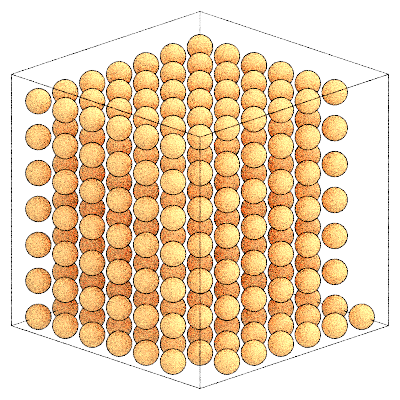

In [42]:
snapshot = hoomd.Snapshot()

N_particles = 300
spacing = 1.42855
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)

positions = list(itertools.product(x, repeat=3))
box= [L,L,L,0,0,0]

snapshot = gsd.hoomd.Snapshot()
snapshot.configuration.box = [L, L, L, 0, 0, 0]
snapshot.particles.N = N_particles
snapshot.particles.position = positions[:N_particles]
snapshot.particles.types = ['A']
snapshot.particles.typeid = [0] * N_particles

print("total number of particles",N_particles)
print("Box length",L)
print("Overall number density",N_particles/(L**3))
render_image(snapshot)

## Create SImulation State and Integrator

In [43]:
sim.create_state_from_snapshot(snapshot)

In [44]:
integrator = hoomd.md.Integrator(dt=0.005)

You need a neighbor list to compte pairwise interactions:

In [45]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

Compute Lennard-Jones interaction forces:
$$V_{\mathrm{LJ}}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

See [Hoomd-blue documentation](https://hoomd-blue.readthedocs.io/en/latest/module-md-pair.html#hoomd.md.pair.LJ) on LJ interactions, and the documentation of `hoomd.md.pair`  for a [list](https://hoomd-blue.readthedocs.io/en/latest/module-md-pair.html) of all availaibe particle pair interactions.

In [46]:
lj = hoomd.md.pair.LJ(nlist=cell,mode='shift')
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)

Set `r_cut` to 2.5:

In [47]:
lj.r_cut[('A', 'A')] = 2.5

Add the `lj` force to the integrator's `forces` list:

In [48]:
integrator.forces.append(lj)

## Cooling the system 

We want to first equilibrate the system at some high temperature ($kT=1.5$ until timestep 10000), and then linearly cooling it down to ($kT=0.5$ at timestep 20000). We do that by defining a ``hoomd.variant.Ramp`` and adding it to the integration method:

In [49]:
all_particles = hoomd.filter.All()
kT_start = 1.5
kT_end = 0.5
# Add code 
# ramp = 
nvt = hoomd.md.methods.NVT(kT=ramp, filter=all_particles, tau=0.5)

You can define all kinds of [variants](https://hoomd-blue.readthedocs.io/en/latest/module-hoomd-variant.html) yourself. Here is an example of how to [compress a system](https://hoomd-blue.readthedocs.io/en/latest/tutorial/01-Introducing-Molecular-Dynamics/03-Compressing-the-System.html) instead of cooling it down. 

Add `nvt` to the integrator's `methods` list:

In [50]:
integrator.methods.append(nvt)

Remember to add the integrator to the simulation operations!

In [51]:
sim.operations += integrator

## Running a molecular dynamics simulation

In [52]:
sim.state.thermalize_particle_momenta(filter=all_particles, kT=kT_start)

## Querying thermodynamic quantities

The `ThermodynamicQuantities` class computes properties of the simulation:

In [53]:
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=all_particles)
sim.operations += thermo

We also want to write out a trajectory:

In [54]:
gsd_writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(5000),
                             filename='trajectory_cooling.gsd',
                             mode='wb')
sim.operations += gsd_writer

## Logging scalar quantities

Use a Logger to monitor how properties of the simulation vary during the run:

In [55]:
logger = hoomd.logging.Logger(categories=['scalar'])

Choose the specific quantities you want to log:

In [56]:
logger.add(sim,quantities=['timestep'])
logger.add(thermo, quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure'])
#thermo.loggables

Use the `Table` writer to display the logged values:

In [57]:
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(1000),
                          logger=logger,
                          max_header_len=5,
                          max_precision=2)
sim.operations += table

We can also save it to a file: 

In [58]:
file = open('log_cooling.txt', mode='w')
table_file = hoomd.write.Table(output=file,
                               trigger=hoomd.trigger.Periodic(100),
                               logger=logger)
sim.operations +=table_file


Now run the simulation for `5000` timesteps.

In [59]:
sim.run(50000)

 timestep  potential_energy kinetic_energy kinetic_temperature  pressure 
   1000       -495.95267      748.63267          1.66919        0.44564  
   2000       -533.92031      700.17114          1.56114        0.36550  
   3000       -523.03528      651.51191          1.45265        0.38904  
   4000       -529.71029      671.89543          1.49809        0.27035  
   5000       -528.70487      676.33989          1.50800        0.23455  
   6000       -500.70347      678.81447          1.51352        0.33213  
   7000       -500.00709      683.18197          1.52326        0.35401  
   8000       -495.96449      684.34634          1.52586        0.36194  
   9000       -530.04163      660.81873          1.47340        0.41810  
  10000       -525.32913      625.44457          1.39453        0.32984  
  11000       -538.80966      622.44566          1.38784        0.24432  
  12000       -539.62525      639.50789          1.42588        0.33369  
  13000       -539.49295      602.1440

We can plot the various thermodynamic quantities:

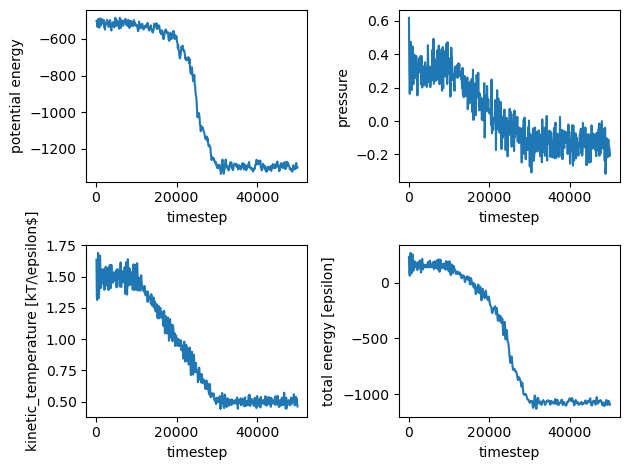

In [60]:
d = numpy.genfromtxt('log_cooling.txt',names = ['timestep','potential_energy','kinetic_energy','kinetic_temperature','pressure'],skip_header=1)

fig, ax = plt.subplots(2,2)


ax[0,0].plot(d['timestep'], d['potential_energy'])
ax[0,0].set_xlabel('timestep')
ax[0,0].set_ylabel('potential energy')

ax[1,0].plot(d['timestep'], d['kinetic_temperature'])
ax[1,0].set_xlabel('timestep')
ax[1,0].set_ylabel('kinetic_temperature [kT/\epsilon$]')

ax[0,1].plot(d['timestep'], d['pressure'])
ax[0,1].set_xlabel('timestep')
ax[0,1].set_ylabel('pressure')


ax[1,1].plot(d['timestep'], d['potential_energy']+d['kinetic_energy'])
ax[1,1].set_xlabel('timestep')
ax[1,1].set_ylabel('total energy [epsilon]')


plt.tight_layout()


The [NIST database](https://www.nist.gov/mml/csd/chemical-informatics-group/lennard-jones-fluid-properties) has a large compilation of LJ data for comparison. 

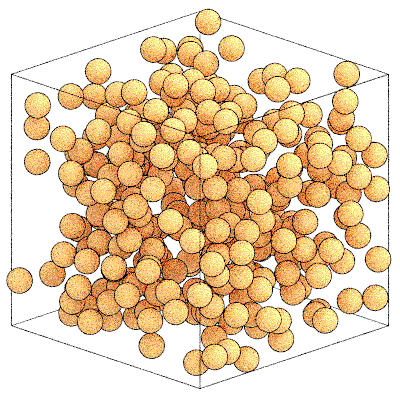

In [61]:
with gsd.hoomd.open('trajectory_cooling.gsd', 'rb') as trajectory:
    image = render_movie(trajectory)
image

In [62]:
del sim, thermo
del logger, gsd_writer
del table_file
del integrator, nvt, lj, cell, cpu